In [1]:
!git clone https://github.com/m-zayan/tfrecord-handler.git

!pip install -q efficientnet

Cloning into 'tfrecord-handler'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 41 (delta 15), reused 40 (delta 14), pack-reused 0
Unpacking objects: 100% (41/41), done.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import sys
import os

import traceback
import logging

import gc
from copy import deepcopy

import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from tqdm.notebook import tqdm

import cv2

import tensorflow as tf

sys.path.insert(0, './tfrecord-handler/')
sys.path.insert(0, '../input/tfrecords-512x512-multiview-3d-hand-pose/multiview_dataset_utils/')

from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets

from tfrecord_handler.io import TfRecordReader
from utils import *

tf.get_logger().setLevel(logging.ERROR)

working_dir = './'

oSHAPE = (480, 640)

# Config TPU

In [5]:
try:
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Running on TPU ', tpu.master())
    
except ValueError:
  
    tpu = None

if tpu is not None:
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    
    strategy = tf.distribute.get_strategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)

assert strategy.num_replicas_in_sync > 1

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [8]:
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

user_secrets.set_tensorflow_credential(user_credential)

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tfrecords-512x512-multiview-3d-hand-pose')

In [9]:
train_rec = tf.io.gfile.glob(GCS_DS_PATH + '/train/train/*')
dev_rec = tf.io.gfile.glob(GCS_DS_PATH + '/dev/dev/*')
test_rec = tf.io.gfile.glob(GCS_DS_PATH + '/test/test/*')

In [10]:
m_train = 32 * 2069 
m_dev = 2 * 2758 + 2760
m_test = 2 * 2758 + 2760


print('No. of training examples: %.2f K'%(m_train / 1e3))
print('No. of dev examples: %.2f K'%(m_dev / 1e3))
print('No. of test examples: %.2f K'%(m_test / 1e3))

No. of training examples: 66.21 K
No. of dev examples: 8.28 K
No. of test examples: 8.28 K


In [11]:
SHAPE = (512, 512)
cSHAPE = (*SHAPE, 3)

batchSize = 16 * strategy.num_replicas_in_sync

n_step_per_epoch = m_train // batchSize
n_epochs = batchSize * 3

dev_steps = m_test // batchSize

AUTOTUNE = tf.data.experimental.AUTOTUNE

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

print('Batch Size :%i\n'%batchSize)

print('No. of step_per_epoch : %i'%n_step_per_epoch)
print('No. of epochs : %i'%n_epochs)

print('\nNo. of dev_steps : %i'%dev_steps)

Batch Size :128

No. of step_per_epoch : 517
No. of epochs : 384

No. of dev_steps : 64


In [12]:
def decode_arr(bytes_str):
    
    return tf.io.decode_raw(bytes_str, out_type='float64')

In [13]:
feature_dtype = {'image': 'bytes', 'bbox': 'bytes'}

processing_func = {'image': lambda x: x / 255.0, 'bbox': decode_arr}

reader = TfRecordReader(features_dtype=feature_dtype, 
                        image_key='image', 
                        tfrecord_shape=(512, 512, 3), 
                        shape=None, 
                        channels=3, 
                        func=processing_func)

# Create TFDataset

In [17]:
tf_train = tf.data.TFRecordDataset(train_rec, num_parallel_reads=AUTOTUNE)
tf_train = tf_train.with_options(ignore_order)

tf_train = tf_train.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
tf_train = tf_train.batch(batchSize)
tf_train = tf_train.prefetch(AUTOTUNE)

In [52]:
tf_dev = tf.data.TFRecordDataset(dev_rec, num_parallel_reads=AUTOTUNE)
tf_dev = tf_dev.with_options(ignore_order)

tf_dev = tf_dev.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
tf_dev = tf_dev.batch(batchSize)
tf_dev = tf_dev.prefetch(AUTOTUNE)

In [53]:
tf_test = tf.data.TFRecordDataset(test_rec, num_parallel_reads=AUTOTUNE)
tf_test = tf_test.with_options(ignore_order)

tf_test = tf_test.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
tf_test = tf_test.batch(batchSize)
tf_test = tf_test.prefetch(AUTOTUNE)

(3, 512, 512, 3)
(3, 4)


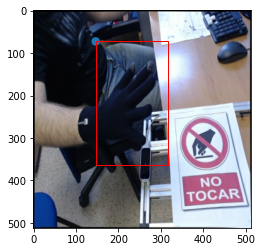

In [18]:
# Test

example = tf_train.unbatch().batch(3).as_numpy_iterator()
sample_x, sample_y = example.next()

print(sample_x.shape)
print(sample_y.shape)

ith = 0

x, y = deepcopy(sample_x[ith]), deepcopy(sample_y[ith])

y[2:] = y[2:] - y[:2]

plot_bbox(x, *y, origin_radius=10)

# Estimating `bbox` - Model

In [19]:
from efficientnet.tfkeras import EfficientNetB0

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Add, Multiply, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

import tensorflow_addons as tfa
from tensorflow.keras import backend as K

In [20]:
def create_model(freeze=1.0, dropout=None):
    
    backbone = EfficientNetB0(include_top=False, weights='imagenet', input_shape=cSHAPE, pooling=None)

    n_layers = len(backbone.layers)

    def backbone_freeze(_freeze=0.8):

        _freeze = int(_freeze * n_layers)

        for i in range(1, _freeze):

            backbone.layers[i].trainable = False
    
    # freeze
    backbone_freeze(freeze)

    inputs = backbone.input

    x = backbone.layers[-1].output
    
    if dropout:
        
        x = Dropout(dropout)(x)
    
    # relu: enforces implicit constraint for output (Bounding Box Coordinates), being positive semidefinite
    # sigmoid: smoothness or scaling factor
    # advantages: its differentiable
    xc =  Conv2D(filters=4, kernel_size=(2, 2), activation='sigmoid', padding='same', strides=1, name='prob')(x)
    xb =  Conv2D(filters=4, kernel_size=(1, 1), activation='relu', padding='same', strides=1, name='y')(x)
    
    x_vec = Multiply()([xc, xb])
    outputs = GlobalAveragePooling2D()(x_vec)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [21]:
def tf_load_model(model_id, custom_objects, compile=False):
    
    path = GCS_DS_PATH + f'/base_models/model_{model_id}/' 
    
    model = tf.keras.models.load_model(filepath=path, compile=compile, custom_objects=custom_objects)
    
    return model 

In [22]:
@tf.function
def localization_loss(y_true, y_pred):
    
    
    loss = tf.norm(y_pred - y_true, axis=-1) ** 2
    loss = K.mean(loss)
    
    return loss

In [23]:
@tf.function
def iou_score(y_true, y_pred):

    def iou(elems):

        _true, _pred = elems

        x_mn = K.maximum(_true[0], _pred[0])
        y_mn = K.maximum(_true[1], _pred[1])

        x_mx = K.minimum(_true[2], _pred[2])
        y_mx = K.minimum(_true[3], _pred[3])

        inter_area = K.maximum(0.0, x_mx - x_mn + 1) * K.maximum(0.0, y_mx - y_mn + 1)

        area_0 = (_true[2] - _true[0] + 1) * (_true[3] - _true[1] + 1)
        area_1 = (_pred[2] - _pred[0] + 1) * (_pred[3] - _pred[1] + 1)

        _iou_val = inter_area / (area_0 + area_1 - inter_area)

        return _iou_val, 0.0
    
    score, _ = tf.map_fn(iou, (y_true, y_pred))
    
    score = K.mean(score)
    
    return score

In [24]:
def lr_scheduler(start, step, factor=0.1):

    def _lr_scheduler(epoch, lr):

        if epoch >= start and (epoch - start) % step == 0:

            return lr * K.exp(-factor)

        else:

            return lr

    return _lr_scheduler


In [25]:
# load model

K.clear_session()

model_id = None
model = None

with strategy.scope():
    
    if model_id is not None:

        custom_objects = {'localization_loss': localization_loss, 
                          'iou_score': iou}

        model = tf_load_model(model_id, custom_objects, compile=False)


    else:
        
        # freeze 100% of backbone model 
        model = create_model(freeze=1.0, dropout=None)
        
    m_callbacks = [EarlyStopping(monitor="val_loss", min_delta=0.05, patience=3, verbose=1, restore_best_weights=False), 
                   LearningRateScheduler(lr_scheduler(20, 50, 0.1), verbose=0)]

    opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(optimizer=opt, loss=localization_loss, metrics=[iou_score])

model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 32) 0           stem_bn[0][0]                    
_____________________________

In [31]:
n_epochs_completed = 50
max_queue_size = 10


history = model.fit(tf_train,
                    epochs=80,
                    initial_epoch = n_epochs_completed, 
                    validation_data=tf_dev,
                    validation_steps=dev_steps,
                    callbacks=m_callbacks,
                    max_queue_size=max_queue_size)

Epoch 51/80
518/518 [==============================] - 42s 81ms/step - iou_score: 0.8194 - loss: 953.1288 - val_iou_score: 0.8401 - val_loss: 704.0847 - lr: 0.0010
Epoch 52/80
518/518 [==============================] - 42s 81ms/step - iou_score: 0.8197 - loss: 951.5143 - val_iou_score: 0.8290 - val_loss: 768.1436 - lr: 0.0010
Epoch 53/80
518/518 [==============================] - 42s 81ms/step - iou_score: 0.8201 - loss: 947.3895 - val_iou_score: 0.8339 - val_loss: 759.3938 - lr: 0.0010
Epoch 54/80
518/518 [==============================] - 42s 82ms/step - iou_score: 0.8205 - loss: 938.2908 - val_iou_score: 0.8383 - val_loss: 710.3609 - lr: 0.0010
Epoch 00054: early stopping


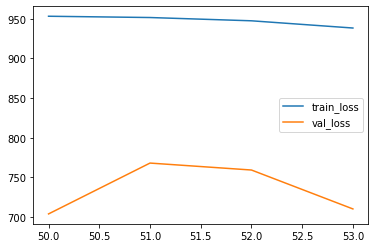

In [32]:
epochs = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)

plt.legend(['train_loss', 'val_loss'])

plt.savefig('loss.png')
plt.show()

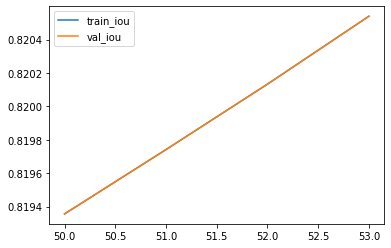

In [33]:
train_iou = history.history['iou_score']
val_iou = history.history['iou_score']

plt.plot(epochs, train_iou)
plt.plot(epochs, val_iou)

plt.legend(['train_iou', 'val_iou'])

plt.savefig('iou_score.png')
plt.show()

In [38]:
# Test Model
examples = tf_test.as_numpy_iterator()
sample_x, sample_y = examples.next()

sample_y = sample_y.astype('float32')

print('dim(sample_x) :', sample_x.shape)
print('dim(sample_y) :', sample_y.shape)

sample_pred = model.predict(sample_x)

print('=' * 40)

print('iou : %f'%iou_score(sample_y, sample_pred))

dim(sample_x) : (16, 512, 512, 3)
dim(sample_y) : (16, 4)
iou : 0.830040


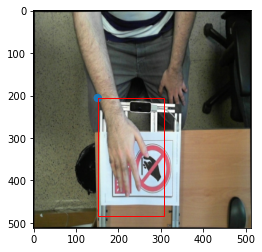

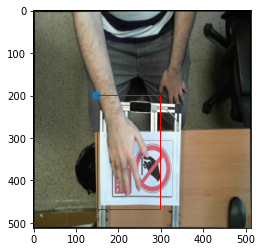

In [41]:
ith = 4

bbox_i = deepcopy(sample_pred[ith])
y_i = deepcopy(sample_y[ith])


bbox_i[2:] = bbox_i[2:] - bbox_i[:2]
y_i[2:] = y_i[2:] - y_i[:2]

plot_bbox(sample_x[ith], *y_i, origin_radius=10)
plot_bbox(sample_x[ith], *bbox_i, origin_radius=10)

# Test Model

In [60]:
score = []

i = 0

for x, y in tf_dev.as_numpy_iterator():
    
    y_pred = model.predict(x)
    
    y_true = y.astype('float32')
    y_pred = y_pred.astype('float32')
    
    iou = iou_score(y_true, y_pred)
    
    if i and i % 10 == 0:
        
        print('iou : %f'%iou)
    
    score.append(iou)
    
    i += 1

iou : 0.835260
iou : 0.834041
iou : 0.832936
iou : 0.845151
iou : 0.832060
iou : 0.858225


In [61]:
score = np.array(score)

print('average score : %f'%score.mean())

average score : 0.834063


# Test Images From Different Distribution

In [ ]:
# ....

# Export Model

In [65]:
def tf_save_model(model, model_id, save_format='h5', compress=False, rm=False):
    
    filename = f'model_{model_id}'
    filepath = working_dir + 'models/'
    
    if not os.path.exists(filepath):
        
        os.mkdir(filepath)
        
    model.save(filepath=filepath + filename, save_format=save_format)
    
    w_filename = f'weights_{model_id}'
    subdir_path = filepath + f'weights/'
    
    if not os.path.exists(subdir_path):
        
        os.mkdir(subdir_path)
        
    model.save_weights(filepath=subdir_path + w_filename, save_format=save_format)

    def save_config():

        filepath = './models/config'

        if not os.path.exists(filepath):

            os.mkdir(filepath)

        path = f'{filepath}/config_{model_id}.json'

        config = json.loads(model.to_json())

        with open(path, 'w') as write_buffer:

            json.dump(config, write_buffer)
    
    
    save_config()
    
    if compress:
        
        !zip -r $f'{filename}.zip' $filepath
    
    if rm:
        
        !rm -r ./models

In [66]:
# save model

save_model = True #@param {type: 'boolean'}
model_id = 1

if save_model:

    tf_save_model(model, 1, compress=True, rm=True)

  adding: models/ (stored 0%)
  adding: models/model_1 (deflated 11%)
  adding: models/weights/ (stored 0%)
  adding: models/weights/weights_1 (deflated 10%)
  adding: models/config/ (stored 0%)
  adding: models/config/config_1.json (deflated 96%)


In [67]:
!rm -r ./tfrecord-handler